In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [2]:
from insilico_mpra.predict import load_model

def load_models(weight_dir, num_models=10):
    models = []
    for i in range(num_models):
        model_path = Path(weight_dir) / str(i) / 'best.ckpt'
        config_path = Path(weight_dir) / str(i) / 'config.json'
        if model_path.exists() and config_path.exists():
            model, _ = load_model(config_path, model_path)
            models.append(model)
        else:
            raise FileNotFoundError(f"Model or config file not found for model {i} at {model_path} or {config_path}")
    return models


weight_dir = '/grid/koo/home/nagai/projects/continual_learning/insilico_mpra/model_weight'
batch_size = 1024
num_workers = 4
N = 30_000

models = load_models(weight_dir, num_models=10)

/grid/koo/home/nagai/projects/continual_learning/insilico_mpra/.venv/lib/python3.10/site-packages/torchmetrics/utilities/imports.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [3]:
outdir = Path('/grid/koo/home/shared/clg_procap/data/mpra/250813')
tsvpath = outdir / 'mpra_loci_K562_fold1_train.tsv'

df = pd.read_csv(tsvpath, sep='\t', index_col=0)
df['header'] = df.apply(lambda row: f"{row['chrom']}_{row['start']}_{row['end']}", axis=1)
df.head()

,chrom,start,end,train_index,start_relative,sequence,header
0,chr10,78030523,78030723,9090,640,GCTGCTTCTGGACTCGCCGCTAACACATCTGCGGCATCCTCTCGGC...,chr10_78030523_78030723
1,chr10,73998684,73998884,9620,970,CCCTTATAAGGAGCGCCCGGCGTTAGGGCTCGGGAATCCGGTAGCA...,chr10_73998684_73998884
2,chr17,39688857,39689057,10916,1100,TGCTCTTCGCACTGCAGTACGCAGTCGCGGTACACCGGCTCACGGT...,chr17_39688857_39689057
3,chr17,41680065,41680265,6685,1310,TAGACGGTCATGGAATTGAGAAGTGGGAGCTTGGGCTCGGCTCCTG...,chr17_41680065_41680265
4,chr6,127268203,127268403,5584,900,TCAGCCCTTTCCGCCACCCCCGCCTTGGCTGCTGGGGCAGGCAAGA...,chr6_127268203_127268403


In [4]:
def seq2onehot(
    sequence,
    alphabet=['A','C','G','T'],
    dtype='int8',
    verbose=False,
):
    # these characters will be encoded as all-zeros
    ambiguous_nucs = ["Y", "R", "W", "S", "K", "M", "D", "V", "H", "B", "X", "N"]

    d = verbose is False

    sequence = sequence.upper()
    if isinstance(sequence, str):
        sequence = list(sequence)

    alphabet = alphabet or np.unique(sequence)
    alphabet_lookup = {char: i for i, char in enumerate(alphabet)}

    ohe = np.zeros((len(sequence), len(alphabet)), dtype=dtype)
    for i, char in enumerate(sequence):
        if char in alphabet:
            idx = alphabet_lookup[char]
            ohe[i, idx] = 1
        else:
            assert char in ambiguous_nucs, char

    return ohe

In [5]:
seqs = df['sequence'].tolist()
onehots = []
for s in seqs:
    onehot = seq2onehot(s)
    onehots.append(torch.from_numpy(onehot).float())
X = torch.stack(onehots).permute(0, 2, 1)
print(X.shape)

torch.Size([30, 4, 200])


In [6]:
class ModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x).unsqueeze(-1)

In [ ]:
from tangermeme.deep_lift_shap import deep_lift_shap

all_attributions = []
for i in range(len(models)):
    models[i].model.eval()
    wrapped_model = ModelWrapper(models[i].model)
    attributions = deep_lift_shap(
        model=wrapped_model,
        X=X,
        batch_size=batch_size,
        n_shuffles=20,
        device='cpu',
    )

    attributions = attributions.cpu().numpy().transpose(0, 2, 1)  # (N, L, 4)
    # print(attributions.shape)
    all_attributions.append(attributions)
attributions = np.mean(np.stack(all_attributions, axis=0), axis=0)  # (N, L, 4)

/grid/koo/home/nagai/projects/continual_learning/insilico_mpra/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/grid/koo/home/nagai/projects/continual_learning/insilico_mpra/.venv/lib/python3.10/site-packages/torch/amp/autocast_mode.py:283: UserWarning: In CPU autocast, but the target dtype is not supported. Disabling autocast.
CPU Autocast only supports dtype of torch.bfloat16, torch.float16 currently.
  warnings.warn(error_message)
/grid/koo/home/nagai/projects/continual_learning/insilico_mpra/.venv/lib/python3.10/site-packages/tangermeme/deep_lift_shap.py:460: RuntimeWarning: Convergence deltas too high: tensor([0.2030, 0.0782, 0.0832, 0.0117, 0.0975, 0.0574, 0.1337, 0.2032, 0.0922,
        0.0059, 0.1183, 0.0340, 0.1405, 0.1817, 0.0467, 0.0034, 0.0042, 0.0643,
        0.0261, 0.0777, 0.5097, 0.3608, 0.5539, 0.2294, 0.4547, 0.1869, 0.1973,
        0.4452, 0.2361, 0.3262, 0.4689, 0.5415, 0.2349

In [8]:
from logomaker_batch.batch_logo import BatchLogo

Processing logos: 100%|██████████| 10/10 [00:00<00:00, 24.20it/s]


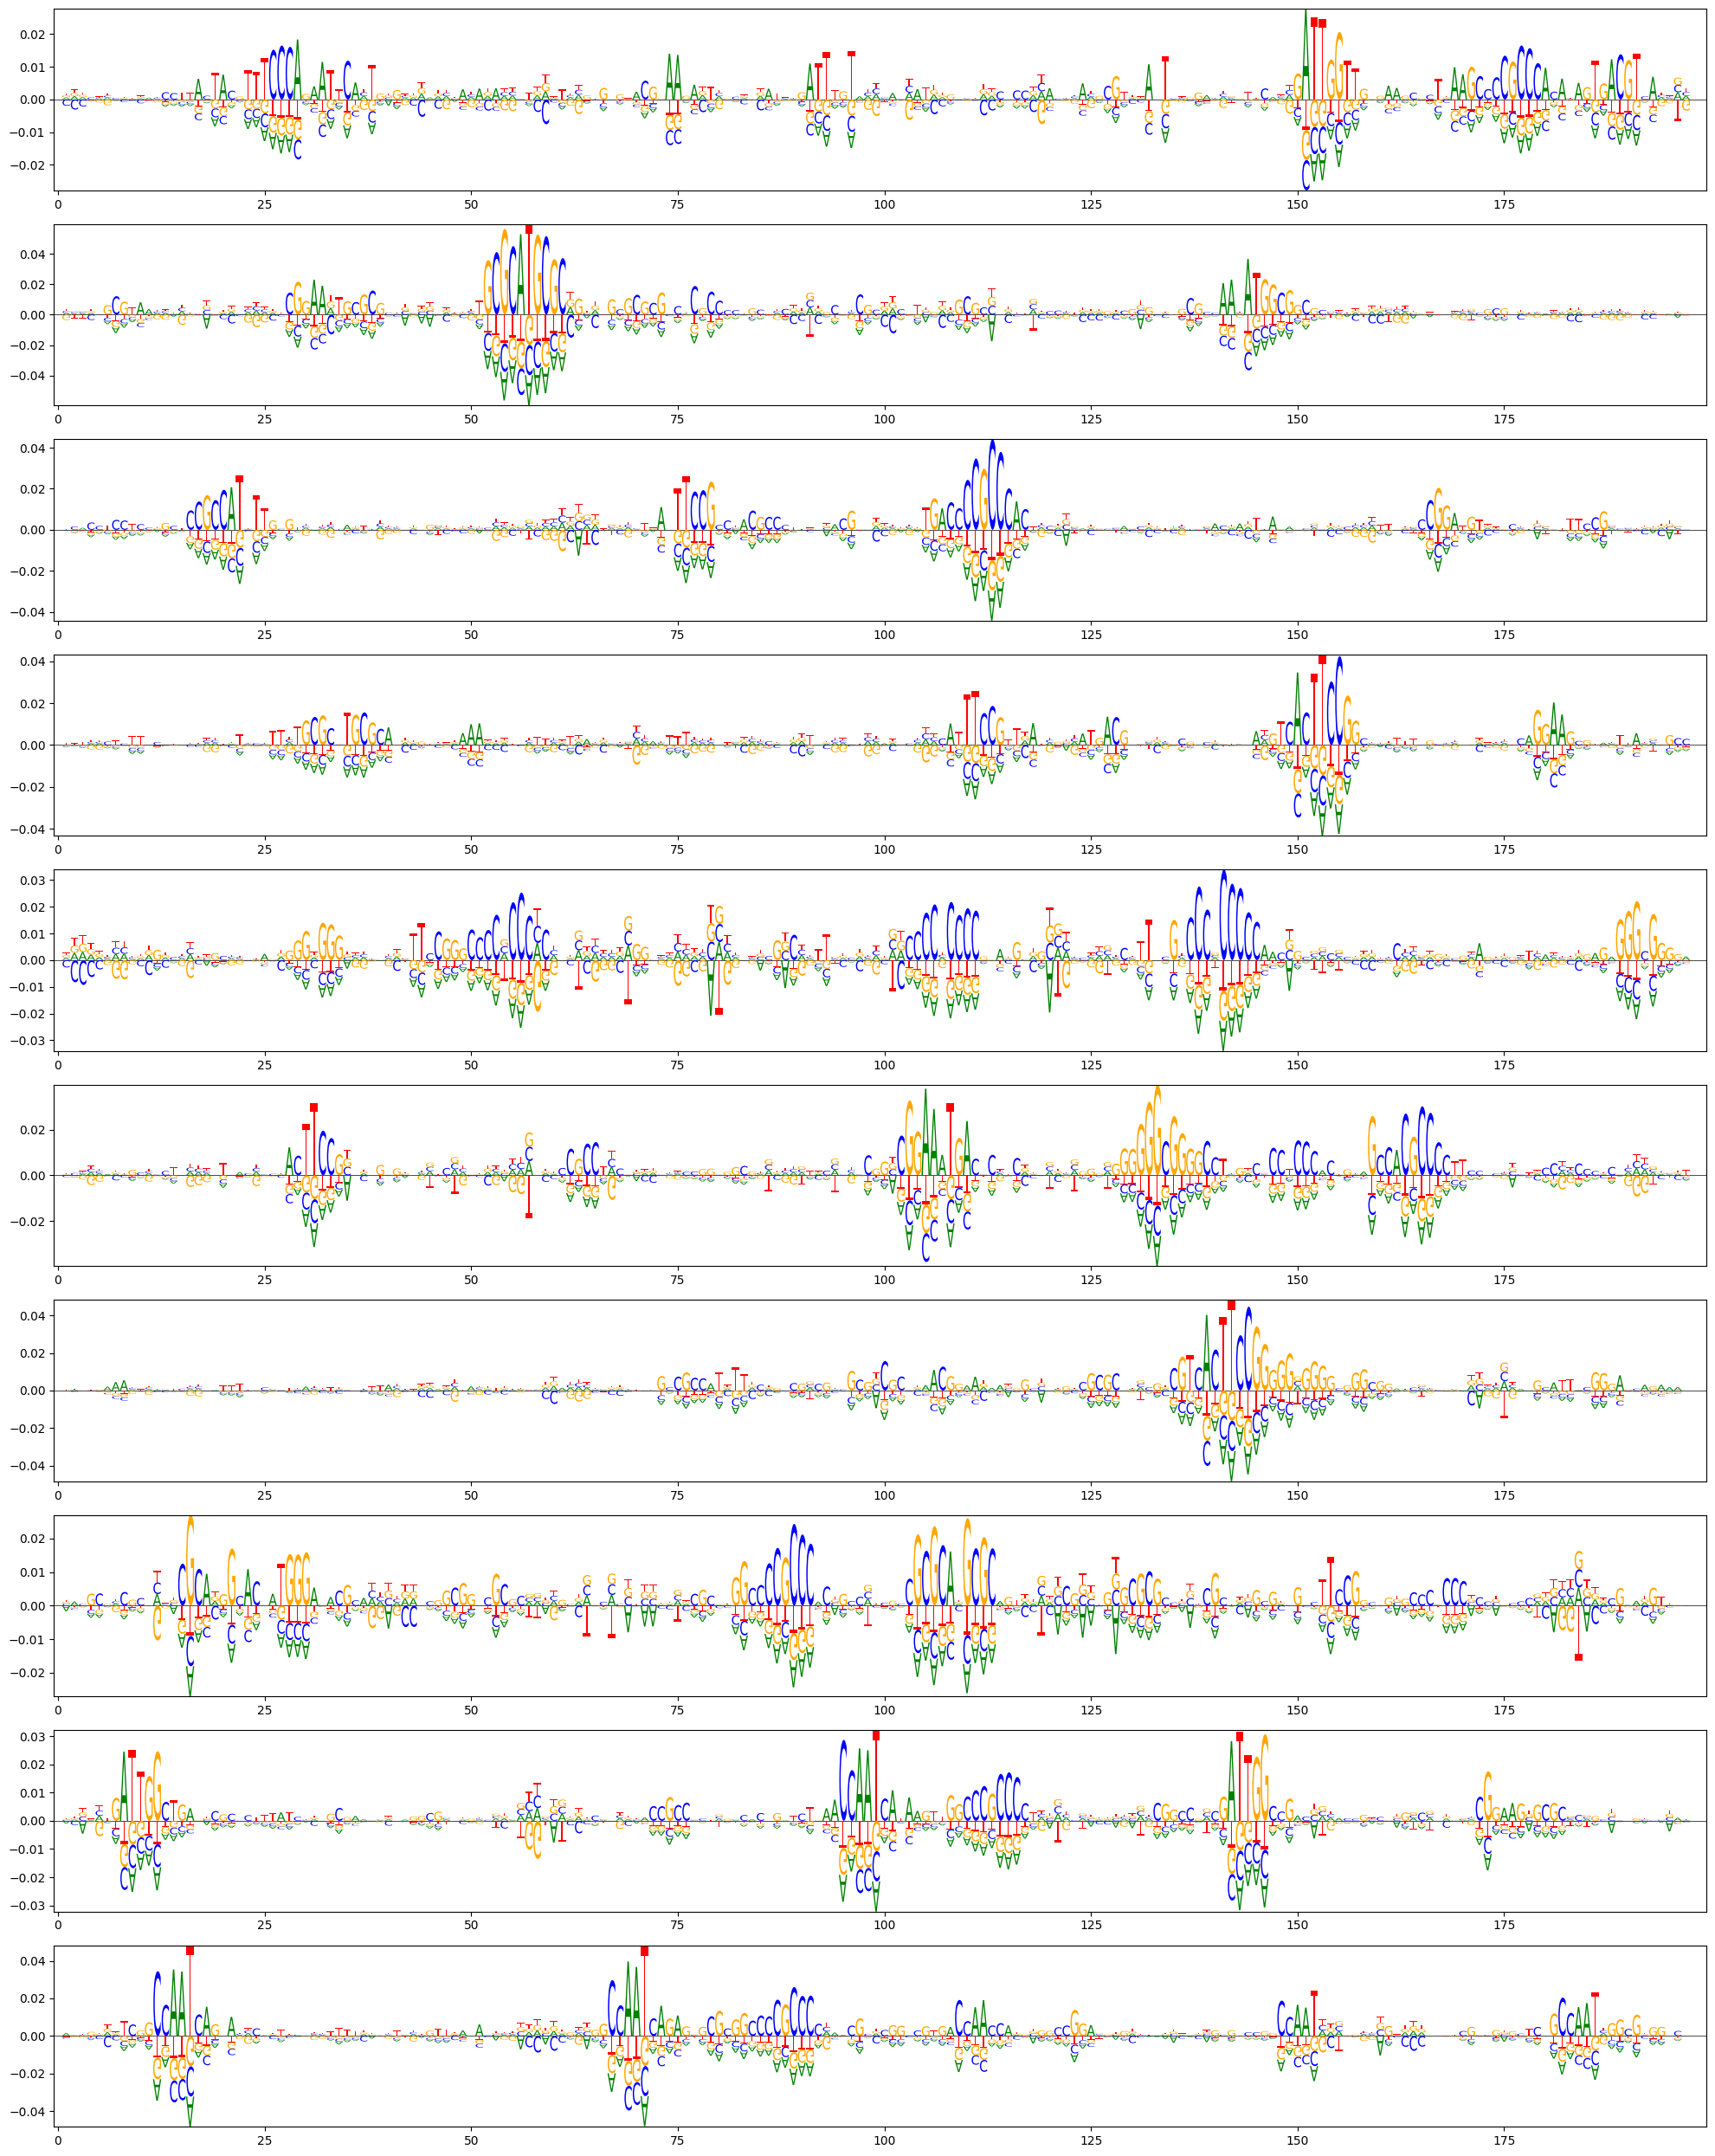

In [ ]:
batch_logo = BatchLogo(
    attributions[10:20],
    alphabet=['A', 'C', 'G', 'T'],
    fig_size=[20, 2.5],
    center_values=True,
    batch_size=1,
    # y_min_max=[y_min, y_max]
)

batch_logo.process_all()

fig, axes = batch_logo.draw_logos(
    indices=None,
    cols=1
)

plt.savefig(f"./deepshap_10-20_centered.png", dpi=150)